In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers.experimental import RMSprop

In [3]:
IMAGE_SIZE = 90
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"Dataset",shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)


Found 610 files belonging to 2 classes.


In [5]:
class_names=dataset.class_names
class_names

['Cataract', 'normal']

In [6]:
len(dataset)

20

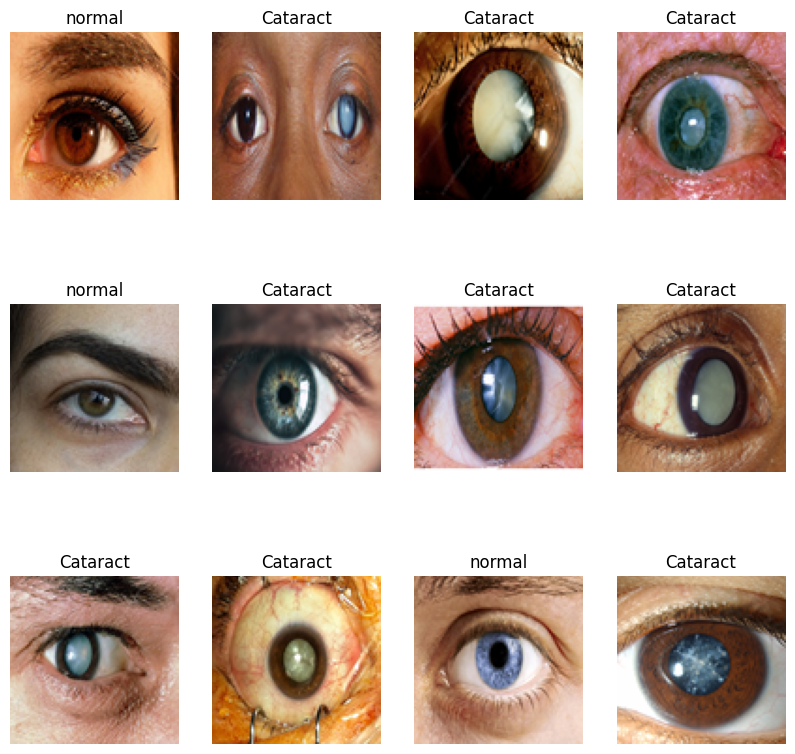

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [9]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [10]:
len(val_ds)

2

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/55)
])

In [13]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

In [14]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = tf.keras.Sequential(
    [
    #  tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu"),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(2)
    ]
)
model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 88, 88, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 44, 44, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 42, 42, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 21, 21, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 19, 19, 32)          9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 9, 9, 32)           

In [16]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [17]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/50
16/16 [==============================] - 4s 127ms/step - loss: 17.6396 - accuracy: 0.5000 - val_loss: 0.7431 - val_accuracy: 0.6719
Epoch 2/50
16/16 [==============================] - 2s 104ms/step - loss: 0.5005 - accuracy: 0.7573 - val_loss: 0.4576 - val_accuracy: 0.7812
Epoch 3/50
16/16 [==============================] - 2s 104ms/step - loss: 0.3202 - accuracy: 0.8693 - val_loss: 0.3092 - val_accuracy: 0.8438
Epoch 4/50
16/16 [==============================] - 2s 130ms/step - loss: 0.2188 - accuracy: 0.9046 - val_loss: 0.2301 - val_accuracy: 0.9375
Epoch 5/50
16/16 [==============================] - 3s 157ms/step - loss: 0.1715 - accuracy: 0.9232 - val_loss: 0.1614 - val_accuracy: 0.9062
Epoch 6/50
16/16 [==============================] - 2s 154ms/step - loss: 0.1141 - accuracy: 0.9544 - val_loss: 0.1954 - val_accuracy: 0.9062
Epoch 7/50
16/16 [==============================] - 2s 152ms/step - loss: 0.0883 - accuracy: 0.9668 - val_loss: 0.0839 - val_accuracy: 0.9688
Epoch

In [18]:
scores=model.evaluate(test_ds)

2/2 [==============================] - 0s 13ms/step - loss: 1.1065 - accuracy: 0.9118


In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

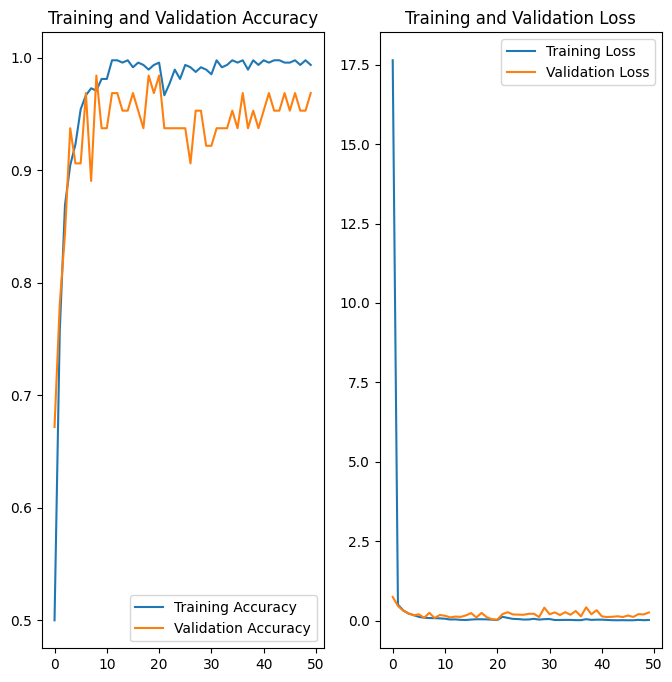

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label normal
1/1 [==============================] - 0s 126ms/step
predicted label: normal


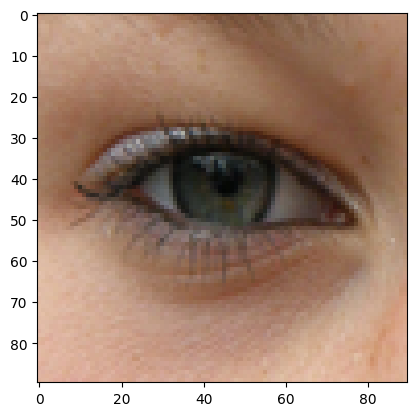

In [21]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label",class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


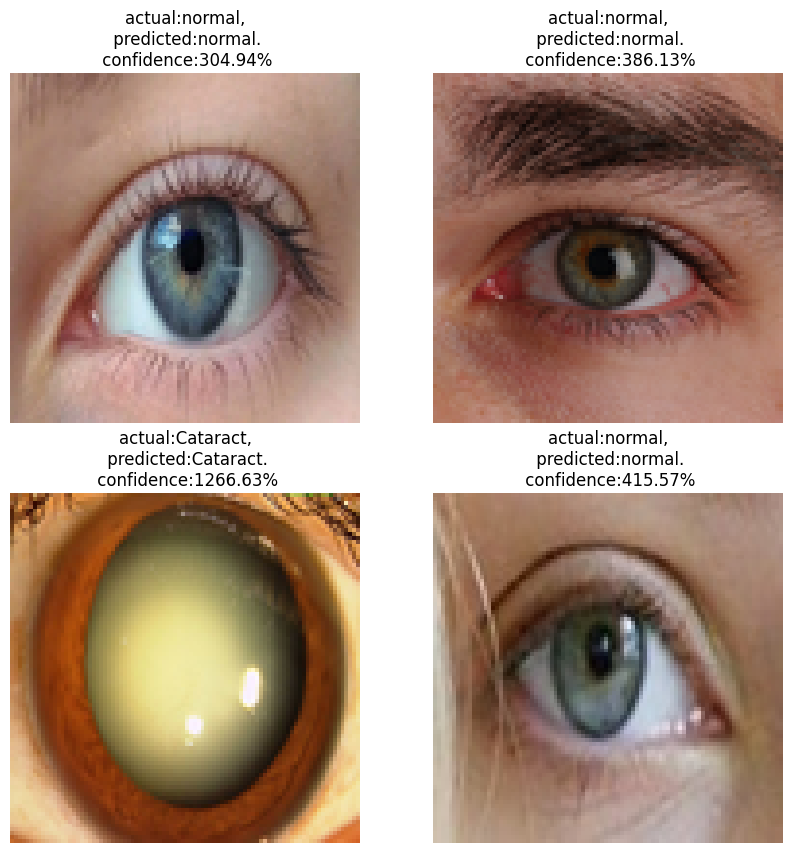

In [23]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    for i in range(4):
        
        ax=plt.subplot(2,2,i+1)
        plt.axis("off")
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"actual:{actual_class},\n predicted:{predicted_class}.\n confidence:{confidence}%")

In [24]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/6\assets


INFO:tensorflow:Assets written to: ../saved_models/6\assets


In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmpjnqtkv65\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmpjnqtkv65\assets
